### Introduction

![title](images/prisontext.png)


In [1]:
from IPython.display import clear_output
import runners, crawler, scrambler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time

#### Plausibility Function

![title](images/plausibility.png)

First, I will define the Plausibility function f(x, s, g) where x is the cipher, s is the scrambled string, and g is conditional bigram probability distribution.

In [2]:
def f(x, s, g):
    y = 0
    for i in range(0, len(s) - 1):
        v = g[x[s[i]]][x[s[i + 1]]]
        if v == 0:
            v = 1 / 50000000
        y += np.log(v)
    return y

I'm going to run the simulation with sample text that was used in the paper. I'm using a sanitize function to handle puctuation, random double spaces, and other formatting anomalies.

In [3]:
o = crawler.sanitize('ENTER HAMLET. HAMLET. To be, or not to be, that is the'
                     ' question: Whether ’tis nobler in the mind to suffer T'
                     'he slings and arrows of outrageous fortune')
print(o)

ENTER HAMLET HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE


I want to see a visualization of the conditional bigram frequencies, so I'll plot it on a heatmap.

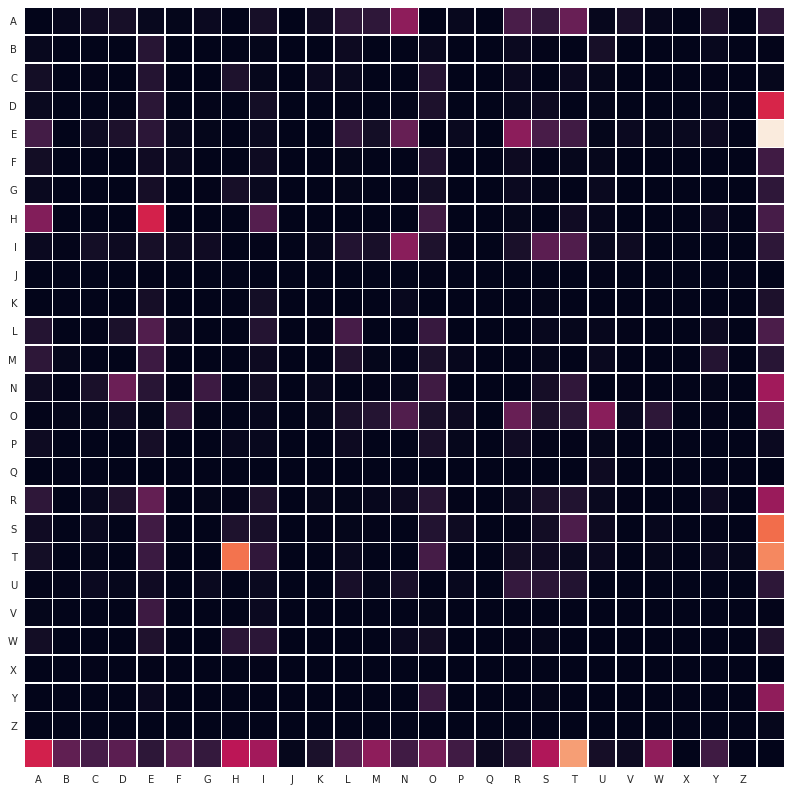

In [4]:
sns.set(rc={'figure.figsize':(14, 14)})
h = crawler.cbfd_from_book('ProjectGutenberg/Hamlet.txt')
sns.heatmap(h, linewidths=.5, square=True, cbar=False, xticklabels=crawler.alphabet, yticklabels=crawler.alphabet)
plt.yticks(rotation=0)
plt.show()

Now I will create the variables needed to run the algorithm. We need a conditional bigram probability distribution g, a scrabled string s, and an initial guess at the cipher x.

In [5]:
g = crawler.cbpd_from_book('ProjectGutenberg/Hamlet.txt')
s = scrambler.scramble(o)
x = dict(zip(crawler.alphabet, crawler.alphabet))
x_ = dict(x)

I define some variables for controlling the algorithms and output to Jupyter Notebook.

In [6]:
max_iterations = 100000
l_sleep = 0
p_interval = 100
hc_p_interval = 1
hc_max_iterations = 200
hc_rrate = 50

# Hill Climbing

In [7]:
x = dict(x_)
iteration = 1
while iteration < hc_max_iterations and scrambler.unscramble_with_cipher(x, s) != o:
    x = runners.hill_climbing(f, x, s, g)
    time.sleep(l_sleep)
    if iteration % hc_p_interval == 0:
        clear_output(wait=True)
        print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))
    iteration += 1
clear_output(wait=True)
print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))

200 EUAED TINSEA TINSEA AR WE RD URA AR WE ATIA BY ATE OMEYABRU CTEATED ABY URWSED BU ATE NBUG AR YMPPED ATE YSBULY IUG IDDRCY RP RMADILERMY PRDAMUE


![title](run_data/hill_climbing_bad.png)

# Hill Climbing with Random Restarts

In [8]:
x = dict(x_)
iteration = 1
while scrambler.unscramble_with_cipher(x, s) != o:
    time.sleep(l_sleep)
    if iteration % hc_p_interval == 0:
        clear_output(wait=True)
        print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))
    x = runners.hill_climbing(f, x, s, g)
    iteration += 1
    if iteration > hc_rrate:
        iteration = 1
        x = runners.swap(runners.swap(dict(x_)))
clear_output(wait=True)
print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))

26 ENTER HAMLET HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE


![title](run_data/hill_climbing.png)

# Metropolis Algorithm

In [10]:
x = dict(x_)
iteration = 1
while iteration < max_iterations and scrambler.unscramble_with_cipher(x, s) != o:
    time.sleep(l_sleep)
    if iteration % p_interval == 0:
        clear_output(wait=True)
        print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))
    x = runners.metropolis(f, x, s, g)
    iteration += 1
clear_output(wait=True)
print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))

1728 ENTER HAMLET HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE


![title](run_data/metropolis.png)

# Metropolis-Hastings Algorithm

In [11]:
x = dict(x_)
iteration = 1
while iteration < max_iterations and scrambler.unscramble_with_cipher(x, s) != o:
    time.sleep(l_sleep)
    if iteration % p_interval == 0:
        clear_output(wait=True)
        print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))
    x = runners.metropolis_hastings(f, x, s, g)
    iteration += 1
clear_output(wait=True)
print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))

7604 ENTER HAMLET HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE


![title](run_data/metropolis_hastings.png)

# Simulated-Annealing Algorithm

In [12]:
x = dict(x_)
iteration = 1
runners.reset_temp()
while iteration < max_iterations and scrambler.unscramble_with_cipher(x, s) != o:
    time.sleep(l_sleep)
    if iteration % p_interval == 0:
        clear_output(wait=True)
        print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))
    x = runners.simulated_annealing(f, x, s, g)
    iteration += 1
clear_output(wait=True)
print('%d %s' % (iteration, scrambler.unscramble_with_cipher(x, s)))

27693 ENTER HAMLET HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE


![title](run_data/simulated_annealing.png)

### Conclusion

Stay away from prisons so you don't have to solve substitution ciphers.